## Credit Card Fraud Detection - Dealing with Imbalanced Classes

Context

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

Dataset Source: Kaggle
    
In this problem we look at **a few ways to handle imbalanced class problem using Credit Card Data**. 

**Objective:** To correctly classify the minority class of fraudulent transactions.


Content

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
# Read data
credit_card_df = pd.read_csv('/users/fara/Downloads/creditcard.csv')
credit_card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# Data types
credit_card_df.shape

(284807, 31)

In [6]:
# Missing values
def missing_values(df):
    total_null = df.isna().sum()
    percent_null = df.isna().sum() / df.count()
    missing_data = pd.concat([total_null, percent_null], axis = 1, 
                             keys = ['Total missing values', 'Percentage missing values']).sort_values('Total missing values')
    return missing_data

missing_values(credit_card_df)

,Total missing values,Percentage missing values
Time,0,0.0
V28,0,0.0
V27,0,0.0
V26,0,0.0
V25,0,0.0
V24,0,0.0
V23,0,0.0
V22,0,0.0
V21,0,0.0
V20,0,0.0


In [7]:
print('Class count:')
print(credit_card_df.Class.value_counts())

Class count:
Class
0    284315
1       492
Name: count, dtype: int64


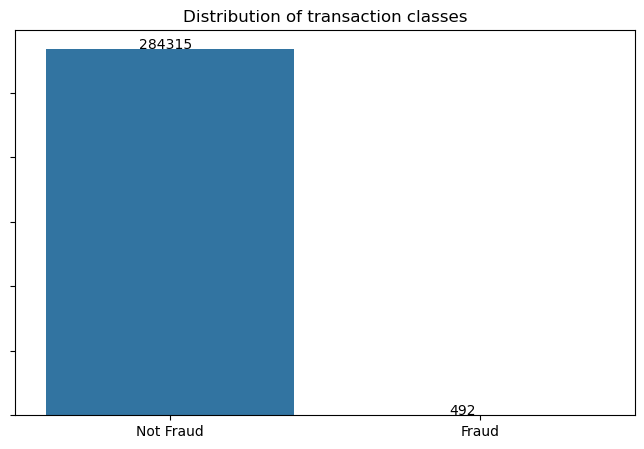

In [9]:
# Plot the class count
fig, ax = plt.subplots(figsize=(8,5))
class_count = sns.countplot(x = 'Class', data = credit_card_df)
class_count.set_xticklabels(['Not Fraud', 'Fraud'])
class_count.set_yticklabels([]) # To disable all value markings on y-axis

# Function to show values on bars
for p in class_count.patches:
    class_count.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+ 0.30, p.get_height()))
    
# Cleaning up the plot
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution of transaction classes', fontsize = 12)
plt.show()

In [10]:
# Percentage of each minor class (FRAUD)
len(credit_card_df.loc[credit_card_df.Class==1]) / credit_card_df.shape[0] *100

0.1727485630620034

- From the above plot we can see that the dataset is highly imbalanced with only **0.17%** of target class(FRAUD)
- This is a problem because many machine learning models are designed to maximize overall accuracy, which especially with imbalanced classes may not be the best metric to use
- Classification accuracy is defined as the number of correct predictions divided by total predictions times 100
- For example, if we simply predicted all transactions are not fraud, we would get a classification acuracy score of over 99%!

#### Train-Test split

In [13]:
from sklearn.model_selection import train_test_split

# Separating input and target
y = credit_card_df.Class
X = credit_card_df.drop('Class', axis = 1) # Drop target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

#### Baseline model with Dummy Classifier with imbalanced data

In [80]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

#### Logistic regression on imbalanced dataset

In [19]:
from sklearn.linear_model import LogisticRegression

lr_imbalanced = LogisticRegression().fit(X_train, y_train)
lr_imbalanced_pred = lr_imbalanced.predict(X_test)

# Results
print('Unique predicted labels: ', np.unique(lr_imbalanced_pred))

# Check accuracy
print('Accuracy score: ', accuracy_score(y_test, lr_imbalanced_pred))

Unique predicted labels:  [0 1]
Accuracy score:  0.9987640796606837


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
# Checking count of predicted values
preds = pd.DataFrame(lr_imbalanced_pred)
preds[0].value_counts()

0
0    71093
1      109
Name: count, dtype: int64

#### Change the performance metric

Accuracy can be very misleading and is not the best metric to use when evaluating imbalanced datasets. 

[Metrics](https://medium.com/towards-data-science/how-to-best-evaluate-a-classification-model-2edb12bcc587) that can provide better insights:

**1. Confusion matrix:**
Table showing correct predictions and types of incorrect predictions. It is used to calculate precision and recall.
- True positive (TP): Predicting positive class as positive 
- False positive (FP): Predicting negative class as positive  ==> Type I error
- False negative (FN): Predicting positive class as negative ==> Type II error
- True negative (TN): Predicting negative class as negative 

**2. Precision:**

$Precision = TP / (TP +FP)$

- The focus of precision is `positive predictions`
- Measures how good the model is at correctly predicting positive classes (PREDICTED positive classes)
- *It indicates how many positive predictions are true*

  
**3. Recall:**

$Recall = TP / (TP + FN)$

- Measures how good the model is at **correctly** predicting positive classes (ACUTAL positive classes)
- *It indicates how many of the positive classes the model is able to predict correctly*

**4. F-1 score:**

$F-1score = 2 * (Precision * Recall) / (Precision + Recall)$

- Harmonic mean of Precision and Recall
- More useful measure than accuracy for problems with uneven class distribution
    - It takes into account both false positive and false negatives
- Ranges from [0,1]

##### Applying f-1 score and recall score to the logistic regression model on imbalanced dataset

In [24]:
# F1-score
print('F-1 score for logistic regression on imbalanced data: ', f1_score(y_test, lr_imbalanced_pred))

# Recall
print('Recall for logistic regression on imbalanced data: ', recall_score(y_test, lr_imbalanced_pred))

F-1 score for logistic regression on imbalanced data:  0.6036036036036037
Recall for logistic regression on imbalanced data:  0.5929203539823009


The score is very low. Lets try by balancing the data 

### Resampling techniques

#### 1. Oversampling minority class

- Defined as adding more copies of the minority class
- It works well if you don't have a lot of data to work with

**NOTE:**
- It's important to split into test and train sets BEFORE resampling techniques
- Oversampling before splitting the data can allow the exact same observations to be present in both the test and train sets
- This can cause the model to remember certain data points and lead to overfitting and poor generalization to test data

In [28]:
# Separating input and target
y = credit_card_df.Class
X = credit_card_df.drop('Class', axis = 1)

In [29]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [30]:
# Putting together X_train and y_train as a training dataframe
X = pd.concat([X_train, y_train], axis = 1)
X.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
83225,59741.0,-1.648591,1.228130,1.370169,-1.735542,-0.029455,-0.484129,0.918645,-0.438750,0.982144,...,-0.218076,-0.203458,-0.213015,0.011372,-0.304481,0.632063,-0.262968,-0.099863,38.42,0
52800,45648.0,-0.234775,-0.493269,1.236728,-2.338793,-1.176733,0.885733,-1.960981,-2.363412,-2.694774,...,-1.495358,-0.083066,0.074612,-0.347329,0.541900,-0.433294,0.089293,0.212029,61.20,0
21293,31579.0,1.134626,-0.774460,-0.163390,-0.533358,-0.604555,-0.244482,-0.212682,0.040782,-1.136627,...,-0.684454,-1.855269,0.171997,-0.387783,-0.062985,0.245118,-0.061178,0.012180,110.95,0
133600,80455.0,0.069514,1.017753,1.033117,1.384376,0.223233,-0.310845,0.597287,-0.127658,-0.701533,...,0.097023,0.369957,-0.219266,-0.124941,-0.049749,-0.112946,0.114440,0.066101,10.00,0
38225,39302.0,-0.199441,0.610092,-0.114437,0.256565,2.290752,4.008475,-0.123530,1.038374,-0.075846,...,-0.019733,0.165463,-0.080978,1.020656,-0.300730,-0.269595,0.481769,0.254114,22.00,0


In [31]:
# Separating minority and majority classes
not_fraud = X[X.Class == 0]
fraud = X[X.Class == 1]

In [32]:
# Oversampling minority class

# Import library
from sklearn.utils import resample

# Upsample
fraud_upsampled = resample(fraud, # The dataframe to resample
                          replace = True, # Sample with replacement
                          n_samples = len(not_fraud), # Resample to same number of observations as from not_fraud
                          random_state = 42) # For reproducibility

# Combining majority and upsampled minority dataframes
upsampled = pd.concat([not_fraud, fraud_upsampled])

# Check class count
upsampled.Class.value_counts()

Class
0    213226
1    213226
Name: count, dtype: int64

##### Logistic regression with balanced dataset (after oversampled minority class data)

In [34]:
# Trying logistic regression again with the balanced dataset
y_train = upsampled.Class
X_train = upsampled.drop('Class', axis = 1)

upsampled_lr = LogisticRegression().fit(X_train, y_train)
upsampled_preds = upsampled_lr.predict(X_test)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [35]:
# Accuracy
print('Accuracy: ', accuracy_score(y_test, upsampled_preds))

# Recall
print('Recall: ', recall_score(y_test, upsampled_preds))

# F-1 score
print('F-1 score: ', f1_score(y_test, upsampled_preds))

# Confusion Matrix
pd.DataFrame(confusion_matrix(y_test, upsampled_preds))

Accuracy:  0.9629926125670627
Recall:  0.9026548672566371
F-1 score:  0.0718562874251497


,0,1
0,68465,2624
1,11,102


- Accuracy score decreased after upsampling, but the model is now predicting both classes more equally
- Recall score increased, but F1 is much lower than with either our baseline logistic regression

#### 2. Undersampling majority class
- Undersampling can be defined as removing some observations of the majority class
- Undersampling can be a good choice when you have an enormous dataset with millions of rows
- **Disadvantage**: 
    - May lead to removal of valuable information
    - Could lead to underfitting and poor generalization to test data

In [38]:
# Downsample
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # Sample without replacement to reduce size
                                n_samples = len(fraud), # Resample to match same size as the minority clas
                                random_state = 42) # For reproducibility

# Combining downsampled majority and minority dataframes
downsampled = pd.concat([not_fraud_downsampled, fraud])

# Check class count
downsampled.Class.value_counts()

Class
0    379
1    379
Name: count, dtype: int64

##### Logistic regression with balanced dataset (after undersampling majority class data)

In [40]:
# Trying logistic regression again with the balanced dataset
y_train = downsampled.Class
X_train = downsampled.drop('Class', axis = 1)

downsampled_lr = LogisticRegression().fit(X_train, y_train)
downsampled_preds = downsampled_lr.predict(X_test)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [41]:
# Accuracy
print('Accuracy: ', accuracy_score(y_test, downsampled_preds))

# Recall
print('Recall: ', recall_score(y_test, downsampled_preds))

# F-1 score
print('F-1 score: ', f1_score(y_test, downsampled_preds))

# Confusion Matrix
pd.DataFrame(confusion_matrix(y_test, downsampled_preds))

Accuracy:  0.9605207718884301
Recall:  0.9292035398230089
F-1 score:  0.06951340615690169


,0,1
0,68286,2803
1,8,105


Undersampling *underperformed* oversampling in this case. Let’s try one more method for handling imbalanced data.

#### 3. Generate synthetic samples
- Similar to oversampling
- Creates synthetic samples
- **[SMOTE](https://towardsdatascience.com/how-to-effortlessly-handle-class-imbalance-with-python-and-smote-9b715ca8e5a7): Synthetic Minority Oversamoling Technique**
- SMOTE uses a nearest neighbours algorithm to generate new and synthetic data, which is used for training the model
- **NOTE:** It’s important to generate the new samples only in the training set to ensure our model generalizes well to unseen data

In [45]:
from imblearn.over_sampling import SMOTE

# Separating input and target
y = credit_card_df.Class
X = credit_card_df.drop('Class', axis = 1) # Drop target variable

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

# SMOTE
sm = SMOTE(random_state = 27)
X_train, y_train = sm.fit_resample(X_train, y_train)

##### Logistic regression after synthetic data generation with SMOTE

In [47]:
# Trying logistic regression again with the balanced dataset after SMOTE
smote_lr = LogisticRegression().fit(X_train, y_train)
smote_preds = smote_lr.predict(X_test)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [48]:
# Accuracy
print('Accuracy: ', accuracy_score(y_test, smote_preds))

# Recall
print('Recall: ', recall_score(y_test, smote_preds))

# F-1 score
print('F-1 score: ', f1_score(y_test, smote_preds))

# Confusion Matrix
pd.DataFrame(confusion_matrix(y_test, smote_preds))

Accuracy:  0.979438779809556
Recall:  0.9026548672566371
F-1 score:  0.1223021582733813


,0,1
0,69636,1453
1,11,102


The F1-score is increased and recall is similar to the upsampled model above and for our data here outperforms undersampling.

#### Conclusion

It appears for this particular dataset **SMOTE** and **oversampling** are among the best of the options we have tried here.

These are just some of the many possible methods to try when dealing with imbalanced datasets. 
- Oversample minority class
- Undersample majority class
- Generate synthetic samples 

Also try using different evaluation metrics for better results. Some others methods to consider are collecting more data or choosing different resampling ratios. 